In [ ]:
# Transfer Learning을 구현
# Fine-Tuning 이용

# 필요한 module import
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense, Dropout
from tensorflow.keras.optimizers import Adam




In [ ]:
#ImageDataGenerator를 이용해서 학습데이터 정의

train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small (1)/train'
validation_dir ='/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small (1)/validation'

train_datagen= ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen =ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],#폴더기능 자동설정
    target_size = (150,150),
    batch_size=20,
    class_mode= 'binary'
)

validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],#폴더기능 자동설정
    target_size = (150,150),
    batch_size=20,
    class_mode= 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# model 구현
# pretrained network을 가져다 사용

model_base =VGG16(weights='imagenet',
                  input_shape=(150,150,3),
                  include_top=False)

# convolution layer 동결

model_base.trainable=False

model = Sequential()

# dnfl model에 pretrained network의 feature extraction을 가져다가 놓아요
model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dense(units=1,
                activation='sigmoid'))

model.add(Dropout(rate=0.5))
model_base.summary()

In [ ]:
# Model 학습 설정하고 학습을 진행
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

In [ ]:
model_base.summary()

In [ ]:
# 일단 이렇게 학습을 한번 진행해야 해요!

# Convolution Layer 동결해제
model_base.trainable = True

# 그런다음 classifier에서 가까운 쪽에 있는 Convolution Layer의
# Filter들만 update가 가능하고 나머지는 update가 안되도록 다시 설정

for layer in model_base.layers:
      if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
          layer.trainable = True
      else:
          layer.trainable = False
# 미세조정(Fine Tuning)을 진행한 후 다시 학습에 대한 설정을 하고
# 재 학습 진행!
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

In [ ]:
#결과를 그래프로 그리기

In [ ]:
# 멍멍이와 고양이 2000개의 이미지로 학습한 결과
# VGG16을 이용한 Transfer Learning(Fine Tuning)을 이용하면
# Accuracy가 약 93%정도 나와요!

In [ ]:
# 마지막으로
# VGG16보다 성능이 더 좋은 efficientnet을 이용해서 transfer learning을 진행해서 결과를 확인
# efficientnet을 설치부터 진행
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten,Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2

train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small (1)/train'
validation_dir ='/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small (1)/validation'

IMAGE_SIZE= 256 # 이 이미지의 크기는 일반적으로 pretrained network을
               # 어떤 종류를 사용하느냐에 따라서 결정

BATCH_SIZE = 8

#python 함수를 하나 정의
# 이미지 전처리에 대한 함수 여기서는 resize만 처리
def GeneratePreprocess(img):
  img = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))
  return img
#augmentation 포함해서 imagedaragenerator를 생성 (train)
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=GeneratePreprocess,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255,
                                        preprocessing_function=GeneratePreprocess)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Pretrained Network Loading

pretrained_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)
)

pretrained_model.trainable = False

# pretrained_model.summary()
model = Sequential()

model.add(pretrained_model)

model.add(Flatten(input_shape=(8*8*1792,)))
model.add(Dense(units=1,
                activation='sigmoid'))

es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=(2000 // BATCH_SIZE),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=(1000 // BATCH_SIZE),
                    callbacks=[es],
                    verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50
250/250 [==============================] - 108s 212ms/step - loss: 0.1129 - accuracy: 0.9555 - val_loss: 0.0363 - val_accuracy: 0.9890
Epoch 2/50
250/250 [==============================] - 49s 197ms/step - loss: 0.0678 - accuracy: 0.9715 - val_loss: 0.0353 - val_accuracy: 0.9870
Epoch 3/50
250/250 [==============================] - 51s 203ms/step - loss: 0.0602 - accuracy: 0.9755 - val_loss: 0.0489 - val_accuracy: 0.9870
Epoch 4/50
250/250 [==============================] - 53s 211ms/step - loss: 0.0907 - accuracy: 0.9745 - val_loss: 0.0497 - val_accuracy: 0.9850
Epoch 5/50
250/250 [==============================] - 49s 195ms/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 0.0661 - val_accuracy: 0.9820
Epoch 6/50
250/250 [==============================] - 49s 197ms/step - loss: 0.0645 - accuracy: 0.9755 - val_loss: 0.0644 - val_accuracy: 0.9830
Epoch 7/50
250/250 [=========================

In [3]:
#TFRecord를 알아보기 위해서 먼저 protocol buffer부터 사용

#어떤 데이터를 저장하고 싶다
# 학생이름, 학과, 학점 이렇게 3개를 저장하고 싶다
# 특정 개체를 만들어서 해당 데이터를 저장
# 저장하려는 객체의 뼈대(class정보)에 대한 정보가 필요한데 그 정보를 가지고 있는 파일이 .proto
# 해당 proto file을 compile을 해서 .py(파이썬 파일)을
# 생성해요! 그래야 이 파일을 사용할 수 있어요!
# 컴파일하려면 protoc 라는 컴파일러가 있어야 해요!
# Colab Runtime에는 이 protoc가 설치되어 있어요!
!protoc example.proto --python_out=.

In [4]:
# 이렇게 컴파일된 proto 파일을 이제 우리 프로그램에서
# 사용해 보아요!
import example_pb2

student =example_pb2.Student()
student.name = 'John'
student.dept ='CS'
student.score =3.14

serialized = student.SerializeToString()

with open('example.pb','wb') as f:
  f.write(serialized)

In [5]:
# 역직렬화
# 직렬화해서 저장된 파일의 내용을 읽어서 원래 객체형태 복구

import example_pb2

student =example_pb2.Student()

with open('example.pb', 'rb') as f:
  serialized =f.read()
  student.ParseFromString(serialized)

  print(student)

name: "John"
dept: "CS"
score: 3.140000104904175



In [7]:
# TFRecord를 만들어 보아요!
# 이미지파일 여러개를 하나의 파일로 만들어보아요!
# CSV가 아닌 이진 데이터 포맷으로 생성!

import tensorflow as tf

filenames = tf.io.gfile.glob('/content/tfrecord_exam/*.jpg')

print(filenames)

['/content/tfrecord_exam/cat.1.jpg', '/content/tfrecord_exam/cat.3.jpg', '/content/tfrecord_exam/cat.4.jpg', '/content/tfrecord_exam/cat.2.jpg', '/content/tfrecord_exam/cat.0.jpg']


/content/tfrecord_exam/cat.1.jpg /content/tfrecord_exam/cat.3.jpg
image의 shape : (414, 500, 3)


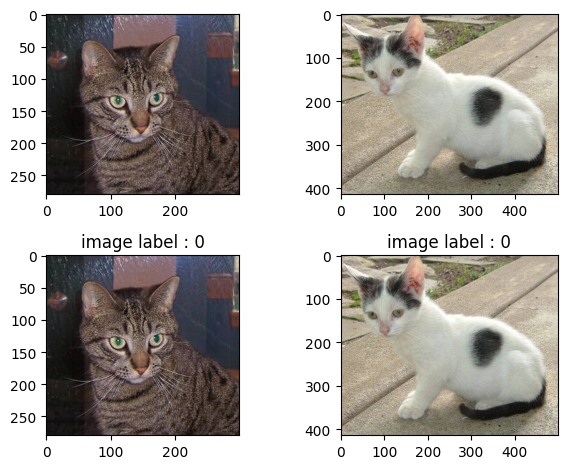

In [8]:
import warnings
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import io

warnings.filterwarnings(action='ignore')

filenames = tf.io.gfile.glob('/content/tfrecord_exam/*.jpg')

print(filenames[0], filenames[1])

# filenames[0], filenames[1] 파일의 shape과 이미지를 먼저 살펴보자.
fig = plt.figure()

axes = []

for i in range(4):
    axes.append(fig.add_subplot(2,2,i+1))

img = Image.open(filenames[0])
pixel = np.array(img)
axes[0].imshow(pixel)

img = Image.open(filenames[1])
pixel = np.array(img)
axes[1].imshow(pixel)


print('image의 shape : {}'.format(pixel.shape))

############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# tf.Example 객체 생성
def to_example(filename):
    image_string = tf.io.read_file(filename)

    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'
    # cat이면 False(0), dog이면 True(1)

    shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# TFRecord 파일 생성
tfrecords_path = './TFRecord_Write_Read_Example.tfrecords'

with tf.io.TFRecordWriter(tfrecords_path) as writer:
    try:
        # print(to_example(filenames[0]).SerializeToString())
        tf_example = to_example(filenames[0])
        writer.write(tf_example.SerializeToString())
        tf_example = to_example(filenames[1])
        writer.write(tf_example.SerializeToString())
    except:
        print('Error 발생')

#######################################################

# TFRecord 파일로 부터 data 복구

raw_image_dataset = tf.data.TFRecordDataset(tfrecords_path)

# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channel': tf.io.FixedLenFeature([], tf.int64),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
    'image/image_raw': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string)
}


def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

k=2

for image_features in parsed_image_dataset:

    image_raw = image_features['image/image_raw'].numpy()  # byte array
    image_label = image_features['image/label'].numpy()  # byte array

    decoded = np.array(Image.open(io.BytesIO(image_raw)))  # ndarray

    axes[k].imshow(decoded)
    axes[k].set_title('image label : {}'.format(image_label))
    k+=1

plt.tight_layout()
plt.show()

In [9]:
#이번에는 멍멍이와 고양이 사진 일부(4000장)을 이용해서 TFRecord 제작
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings(action='ignore')

############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def to_example(filename):
    # TFRecord를 생성하는 시점에 resize를 할수도 있고 TFRecord를 읽어서 DataSet을 만들때
    # resize를 할 수 도 있다.
    # resize 된 이미지를 저장할 경우 처리에 주의해야 한다.
    # 잘못하는 경우 이미지 데이터가 깨져서 저장될 수 있음.
    # 일반적으로 원본을 저장하고 사용할 때 resize해서 사용하는것이 일반적임.

    # 원본 이미지를 resize하지 않고 TFRecord로 저장.
    image_string = tf.io.read_file(filename)

    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'
    # cat이면 False(0), dog이면 True(1)

    shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())
    }

    # Example 객체 생성
    # 파이썬의 문자열은 모두 unicode. unicode 문자열을 byte배열로 바꾸는 함수가 encode()
    # 각 type에 맞게 Feature 객체 생성 후 dict 생성.
    # 이 dict를 이용해 Feauture 객체 생성 후 Example 객체 생성.
    return tf.train.Example(features=tf.train.Features(feature=feature))


def chunkify(filename_list, n):
    size = len(filename_list) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(filename_list[start:start + size])
        start += size
    results.append(filename_list[start:])
    return results


# tqdm은 반복문의 진행상황을 progressbar를 보여주는 모듈

# tqdm 파라미터
# iterable : 반복자 객체
# desc : 진행바 앞에 텍스트 출력
# total : int, 전체 반복량
# leave : bool, default로 True. (진행상태 잔상이 남음)
# ncols : 진행바 컬럼길이. width 값으로 pixel 단위로 보임.
# mininterval, maxinterval : 업데이트 주기.
#                            기본은 mininterval=0.1 sec, maxinterval=10 sec
# miniters : Minimum progress display update interval, in iterations.
# ascii : True로 하면 '#'문자로 진행바가 표시됨.
# initial : 진행 시작값. 기본은 0
# bar_format : str

# tqdm method
# clear() : 삭제
# refresh() : 강제 갱신

def build_tfrecords(total_shards_num, split, filenames):
    chunks = chunkify(filenames, total_shards_num)
    failed = 0
    for i, chunk in tqdm(enumerate(chunks),
                         total=len(chunks),
                         position=0,
                         leave=True):
        tfrecords_path = './tfrecords/{}_{}_of_{}.tfrecords'.format(split,
                                                                    str(i + 1).zfill(4),
                                                                    str(total_shards_num).zfill(4))
        # GZIP으로 압축한 TFRecord 생성하기 위한 option
        # options = tf.io.TFRecordOptions(compression_type='GZIP')

        # with tf.io.TFRecordWriter(tfrecords_path, options=options) as writer:
        with tf.io.TFRecordWriter(tfrecords_path) as writer:
            for filename in chunk:
                try:
                    tf_example = to_example(filename)

                    # 만들어진 Example 객체를 binary string으로 변환한 후 파일에 저장
                    writer.write(tf_example.SerializeToString())
                except:
                    print(f'fail: {filename}')


os.makedirs('tfrecords', exist_ok=True)
filenames = tf.io.gfile.glob('/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/*.jpg')

train_data, valid_data = train_test_split(filenames, train_size=0.8)

build_tfrecords(100, 'train', train_data)
build_tfrecords(100, 'valid', valid_data)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

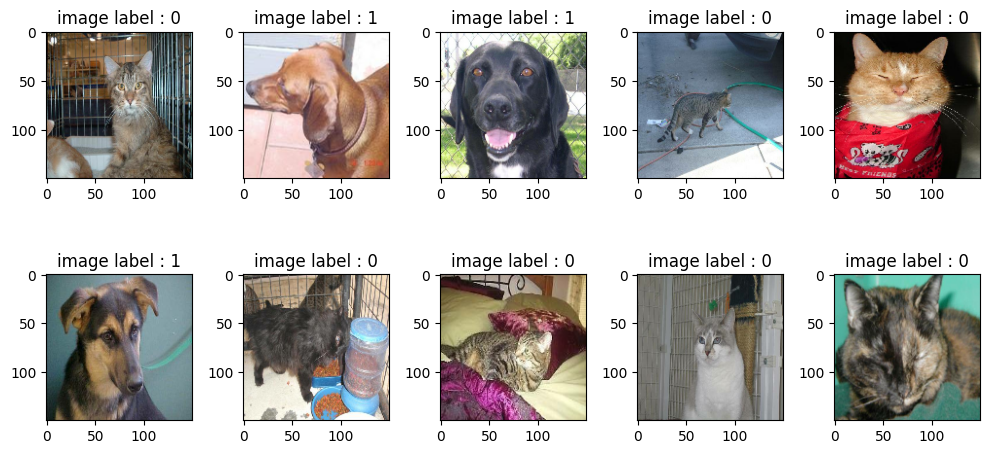

In [10]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# train, validation TFRecord 예제 파일 경로
train_tfrecord_path = './tfrecords/train_0001_of_0100.tfrecords'

# TFRecord 파일을 불러와서 모델 학습 및 추론에 사용하기 위해서는
# tf.data.Dataset 모듈과 유사한 기능을 가지는 tf.data.TFRecordDataset 모듈을 이용
# tf.data.Dataset 모듈은 여러 방식으로 데이터를 불러올 수 있는데 기본적으로는
# generator로 부터 데이터를 불러온다. TFRecordDataset도 마찬가지임.
# 아래의 parameter는 TFRecordDataset를 사용할 때의 parameter

BUFFER_SIZE = 2     # 데이터 shuffle을 위한 buffer size
BATCH_SIZE = 32     # 배치 사이즈. 한번에 가져오는 이미지 데이터 개수
NUM_CLASS = 2        # class의 개수. binary인 경우는 필요없으며 categorical인 경우 설정
IMAGE_SIZE = 150


# TFRecord를 읽어서 데이터를 복원하기 위한 자료구조.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channel': tf.io.FixedLenFeature([], tf.int64),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
    'image/image_raw': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string)
}

# 읽어들인 TFRecord를 다음의 형태(dict)로 변환하는 함수
# <ParallelMapDataset shapes: {id: (), image_raw: (), label: ()},
#                     types: {id: tf.string, image_raw: tf.string, label: tf.int64}>
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto,
                                      image_feature_description)

# 위에서 얻은 ParallelMapDataset를 다음의 형태(shape)로 변환하는 함수
# <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
def map_func(target_record):
    img = target_record['image/image_raw']
    label = target_record['image/label']
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label


# 전처리(normalization & resize) 함수
# 이미지 데이터 normalization
# 우리예제는 TFRecord 생성 시 원본 size로 저장했기 때문에 image resize를 해야함.
def image_preprocess_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image,
                                   (IMAGE_SIZE,IMAGE_SIZE),
                                   antialias=False)
    return result_image, label


# 만약 multinomial classification이면 one_hot처리도 필요함.
def image_postprocess_func(image, label):
#    onehot_label = tf.one_hot(label, depth=1049)    # binary인 경우 one_hot 사용안함.
    return image, label


# 만약 GZIP 압축파일 형식으로 tfrecord가 되어있다면 아래와 같이 option처리
# dataset = tf.data.TFRecordDataset(train_tfrecord_path,
#                                   compression_type='GZIP')
dataset = tf.data.TFRecordDataset(train_tfrecord_path)

dataset = dataset.map(_parse_image_function,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.map(map_func,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# dataset = dataset.cache()

dataset = dataset.shuffle(BUFFER_SIZE)

dataset = dataset.map(image_preprocess_func,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# one_hot encoding 처리
dataset = dataset.map(image_postprocess_func,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# BatchDataset으로 변환
# <BatchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>
# BatchDataset으로 변환하기 전에 image의 resize(전처리)가 일어나야 한다. 그렇지 않으면
# shape이 달라 batch처리가 되지 않는다는 오류 발생.
dataset = dataset.batch(BATCH_SIZE)


# prefetch처리
# prefetch는 전처리와 학습과정의 모델 실행을 오버랩.
# 모델이 s스텝 학습을 실행하는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽어서 수행속도를 높임.
# <PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# validation set에 대해서도 동일하게 처리(shuffle 제외)


# 1개의 batch만 얻어와서 그 중 10개의 이미지만 출력
# 현재 batch size가 32이기 때문에 32개의 이미지를 가져온다.
# binary classification은  label처리 시 np.argmax()와 같은 처리가 필요없지만
# multinomial classification은 np.argmax()로 label 출력

fig = plt.figure(figsize=(10,5))
axs = []

for i in range(10):
    axs.append(fig.add_subplot(2,5,i+1))


# 1번의 batch를 가져온다.
for batch_img, batch_label in dataset:

    for i in range(10):
        image_raw = batch_img[i]
        image_label = batch_label[i]
        axs[i].imshow(image_raw)
        axs[i].set_title('image label : {}'.format(image_label))

    break

plt.tight_layout()
plt.show()

In [11]:
import os
import tensorflow as tf

# 학습에 필요한 DataSet 준비(여러개의 tfrecord 처리)

# train, validation TFRecord 폴더 경로(여러개의 tfrecord 처리)
# 폴더를 나누고 파일을 복사하는건 수동으로 처리
train_tfrecord_path = './tfrecords/train'
valid_tfrecord_path = './tfrecords/valid'

train_tfrecord_list = tf.io.gfile.glob(train_tfrecord_path + '/*.tfrecords')
valid_tfrecord_list = tf.io.gfile.glob(valid_tfrecord_path + '/*.tfrecords')

# 읽어들인 TFRecord를 다음의 형태(dict)로 변환하는 함수
# <ParallelMapDataset shapes: {id: (), image_raw: (), label: ()},
#                     types: {id: tf.string, image_raw: tf.string, label: tf.int64}>
def _parse_image_function(example_proto):
    # TFRecord를 읽어서 데이터를 복원하기 위한 자료구조.
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/channel': tf.io.FixedLenFeature([], tf.int64),
        'image/label': tf.io.FixedLenFeature([], tf.int64),
        'image/image_raw': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example_proto,
                                      image_feature_description)

# 위에서 얻은 ParallelMapDataset를 다음의 형태(shape)로 변환하는 함수
# <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
def map_func(target_record):
    img = target_record['image/image_raw']
    label = target_record['image/label']
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label


# 전처리(normalization & resize) 함수
# 이미지 데이터 normalization
# 우리예제는 TFRecord 생성 시 원본 size로 저장했기 때문에 image resize를 해야함.
def image_preprocess_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image,
                                   (IMAGE_SIZE,IMAGE_SIZE),
                                   antialias=False)
    return result_image, label


# 만약 multinomial classification이면 one_hot처리도 필요함.
def image_postprocess_func(image, label):
#    onehot_label = tf.one_hot(label, depth=1049)    # binary인 경우 one_hot 사용안함.
    return image, label


def make_dataset(tfrecords_path, is_train):

    dataset = tf.data.TFRecordDataset(tfrecords_path)

    dataset = dataset.map(_parse_image_function,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(map_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(image_preprocess_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(image_postprocess_func,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [22]:
!mv /content/tfrecords/valid_*.tfrecords /content/tfrecords/valid

mv: cannot stat '/content/tfrecords/valid_*.tfrecords': No such file or directory


In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


############### Parameter
NUM_OF_TFRECORDS = 5 # 종류별 TFRecord의 개수
BUFFER_SIZE = 16     # 데이터 shuffle을 위한 buffer size
BATCH_SIZE = 8       # 배치 사이즈. 한번에 가져오는 이미지 데이터 개수
NUM_CLASS = 2        # class의 개수. binary인 경우는 필요없으며 categorical인 경우 설정
IMAGE_SIZE = 150

############### Model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_layer')

## Pretrained Network
pretrained_model = VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                         input_tensor=input_layer)

pretrained_model.trainable = False

x = pretrained_model.output

x = Flatten()(x)
x = Dense(256,
          activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=x)


# EarlyStopping & Checkpoint & Learning Rate
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_acc",
                        patience = 3,
                        factor = 0.5,
                        min_lr=1e-7,
                        verbose=1)

model_filename = './checkpoint/cat-dog-{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.hdf5'

checkpointer = ModelCheckpoint(
    filepath=model_filename,
    verbose=1,
    save_freq='epoch',
    save_best_only=True,
    monitor='val_acc')

es = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

# LearningRateScheduler 이용
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])



# 데이터 세팅 후 학습(여러개(100개)의 tfrecord를 이용한 학습)
for i in tqdm(range(NUM_OF_TFRECORDS),
              total=NUM_OF_TFRECORDS,
              position=0,
              leave=True):
    tfrecord_train_file = train_tfrecord_list[i]
    tfrecord_valid_file = valid_tfrecord_list[i]

    dataset = make_dataset(tfrecord_train_file, True)
    valid_dataset = make_dataset(tfrecord_valid_file, False)

    model.fit(dataset,
              epochs=20,
              validation_data=valid_dataset,
#               callbacks = [checkpointer, es, learning_rate_reduction],
              callbacks = [checkpointer],
              verbose=0)

print('############### 기본학습 종료 ###############')

# 여기까지가 기본학습 처리입니다.

# Pretrained Network 위에 새로운 Network을 추가합니다.
# Base Network을 동결합니다.
# 새로 추가한 Network을 학습합니다.


# 아래의 작업이 추가로 필요합니다.
# Base Network에서 일부 Layer의 동결을 해제합니다.
# 동결을 해제한 층과 새로 추가한 층을 함께 학습합니다.

pretrained_model.trainable = True

for layer in pretrained_model.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

## learning rate를 줄이는게 일반적(미세조절)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])



## 재학습 진행
print('########### 재학습 진행 ###########')

for i in tqdm(range(NUM_OF_TFRECORDS),
              total=NUM_OF_TFRECORDS,
              position=0,
              leave=True):

    tfrecord_train_file = train_tfrecord_list[i]
    tfrecord_valid_file = valid_tfrecord_list[i]

    dataset = make_dataset(tfrecord_train_file, True)
    valid_dataset = make_dataset(tfrecord_valid_file, False)

    model.fit(dataset,
              epochs=20,
              validation_data=valid_dataset,
#               callbacks = [checkpointer, es, learning_rate_reduction],
              callbacks = [checkpointer],
              verbose=0)

  0%|          | 0/5 [00:00<?, ?it/s]

IndexError: ignored